<a href="https://colab.research.google.com/github/shelyao/AI-quantitative-research/blob/master/Muti_Stock_Model_yx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jqdatasdk
!pip install pyts
from jqdatasdk import *
import pandas as pd
import numpy as np
from pyts.image import GramianAngularField
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, models
# phone number / password for joinquant
auth('18720012430','Luoluoblue1991')

     |████████████████████████████████| 153kB 7.7MB/s 
     |████████████████████████████████| 368kB 8.0MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
  Created wheel for thriftpy2: filename=thriftpy2-0.4.14-cp37-cp37m-linux_x86_64.whl size=940273 sha256=e8fb353148e9446aa90402cbf8439bb79ae0ebde2514541e80a316f59f06ba87
  Stored in directory: /root/.cache/pip/wheels/89/c6/6b/c94a9a90153934a39a26ed4d94254d0e347b706f989b526c8b
Successfully built thriftpy2
     |████████████████████████████████| 2.5MB 7.7MB/s 
提示：当前环境 pandas 版本高于 0.25，get_price 与 get_fundamentals_continuously 接口 panel 参数将固定为 False
注意：0.25 以上版本 pandas 不支持 panel，如使用该数据结构和相关函数请注意修改
auth success 


In [2]:
def get_test_data(security, start, end):
  st = 42 # starting day index
  test_df_daily = get_price(security, start_date=start, end_date=end, frequency='daily')
  test_df_hour = get_price(security, start_date=start, end_date=end, frequency='60m')

  test_trading_hour = list(test_df_hour.index)
  test_trading_day = list(test_df_daily.index)

  test_data = []
  for index in range(st, len(test_trading_day)-2):
    tmp = {}
    tmp['time'] = test_trading_day[index].date()
    end_index = test_trading_day.index(test_trading_day[index]) + 1
    start_index = end_index - 10
    tmp['day_close'] = list(test_df_daily[start_index:end_index]['close'])
    tmp['day_high'] = list(test_df_daily[start_index:end_index]['high'])
    tmp['day_open'] = list(test_df_daily[start_index:end_index]['open'])
    tmp['day_low'] = list(test_df_daily[start_index:end_index]['low'])
    tmp['day_volume'] = list(test_df_daily[start_index:end_index]['volume'])
    tmp['reward'] = float(test_df_daily[end_index:end_index+1]['open']) - float(test_df_daily[end_index-1:end_index]['open'])
    end_index = test_trading_hour.index(test_trading_day[index+1].date())
    start_index = end_index - 10
    tmp['hour_close'] = list(test_df_hour[start_index:end_index]['close'])
    tmp['hour_high'] = list(test_df_hour[start_index:end_index]['high'])
    tmp['hour_open'] = list(test_df_hour[start_index:end_index]['open'])
    tmp['hour_low'] = list(test_df_hour[start_index:end_index]['low'])
    tmp['hour_volume'] = list(test_df_hour[start_index:end_index]['volume'])
    test_data.append(tmp)

  test_image_data = []
  for index in range(len(test_data)):
    sample_input = test_data[index]
    transformer = GramianAngularField()
    sample_day_close = np.array(sample_input['day_close']).reshape(1,10)
    sample_day_high = np.array(sample_input['day_high']).reshape(1,10)
    sample_day_open = np.array(sample_input['day_open']).reshape(1,10)
    sample_day_low = np.array(sample_input['day_low']).reshape(1,10)
    sample_day_volume = np.array(sample_input['day_volume']).reshape(1,10)
    sample_hour_close = np.array(sample_input['hour_close']).reshape(1,10)
    sample_hour_high = np.array(sample_input['hour_high']).reshape(1,10)
    sample_hour_open = np.array(sample_input['hour_open']).reshape(1,10)
    sample_hour_low = np.array(sample_input['hour_low']).reshape(1,10)
    sample_hour_volume = np.array(sample_input['hour_volume']).reshape(1,10)
    new_sample_day_close = transformer.transform(sample_day_close)
    new_sample_day_high = transformer.transform(sample_day_high)
    new_sample_day_open = transformer.transform(sample_day_open)
    new_sample_day_low = transformer.transform(sample_day_low)
    new_sample_day_volume = transformer.transform(sample_day_volume)
    new_sample_hour_close = transformer.transform(sample_hour_close)
    new_sample_hour_high = transformer.transform(sample_hour_high)
    new_sample_hour_open = transformer.transform(sample_hour_open)
    new_sample_hour_low = transformer.transform(sample_hour_low)
    new_sample_hour_volume = transformer.transform(sample_hour_volume)
    sample_image = np.zeros((30,30))
    for i in range(0,10):
      for j in range(0,10):
        sample_image[i][j] = new_sample_day_close[0][i][j]
    for i in range(0,10):
      for j in range(10,20):
        sample_image[i][j] = new_sample_day_high[0][i][j-10]
    for i in range(0,10):
      for j in range(20,30):
        sample_image[i][j] = new_sample_day_open[0][i][j-20]
    for i in range(10,20):
      for j in range(0,10):
        sample_image[i][j] = new_sample_hour_close[0][i-10][j]
    for i in range(10,20):
      for j in range(10,20):
        sample_image[i][j] = new_sample_hour_high[0][i-10][j-10]
    for i in range(10,20):
      for j in range(20,30):
        sample_image[i][j] = new_sample_hour_open[0][i-10][j-20]
    for i in range(20,30):
      for j in range(0,10):
        sample_image[i][j] = new_sample_day_low[0][i-20][j]
    for i in range(20,30):
      for j in range(10,20):
        sample_image[i][j] = new_sample_hour_low[0][i-20][j-10]
    for i in range(20,30):
      for j in range(20,30):
        sample_image[i][j] = new_sample_day_volume[0][i-20][j-20]
    show_img = sample_image
    sample_image = sample_image.reshape((30,30,1))
    test_image_data.append(sample_image)
  return test_data, test_image_data, test_df_daily

def get_security_list(start, end, security_list = ['600519.XSHG', '601318.XSHG', '000858.XSHG', '600036.XSHG', '600276.XSHG', '000333.XSHE', '000651.XSHE', '600030.XSHG', '002475.XSHE']):
  tmp_data_list = []
  tmp_image_data_list = []
  open_price = []
  st=42
  for security in security_list:
    print(security)
    data, image_data, df_daily = get_test_data(security, start, end)
    tmp_data_list.append(data)
    tmp_image_data_list.append(image_data)
    open_price.append(df_daily[st:]['open'])
  length = len(tmp_data_list[0])
  data = []
  image_data = []
  for i in range(length):
    tmp_data = []
    for j in range(len(tmp_data_list)):
      tmp_data.append(tmp_data_list[j][i])
    data.append(tmp_data)

    tmp_image_data = [[[] for _ in range(30)] for _ in range(30) ]
    for x in range(30):
      for y in range(30):
        for j in range(9):
          tmp_image_data[x][y].append(tmp_image_data_list[j][i][x][y][0])
    
    image_data.append(tmp_image_data)
  return data, image_data, df_daily, open_price

In [3]:
# simulate environment
class Env:
  def __init__(self, data, image_data):
    self.data = data
    self.image_data = image_data
    self.index = 0
    self.length = len(data) - 1
    self.done = False
    self.actions = self.generate_action()

  def current_state(self):
    return [self.index, self.data[self.index], self.image_data[self.index]]

  def step(self, action):
    if self.done:
      return 0, True
    
    self.index += 1
    reward = 0
    # change reward here
    for i in range(9):
      tmp = self.actions[action][i]
      tmp = tmp / self.data[self.index][i]['day_open'][-1]
      tmp = tmp * self.data[self.index][i]['reward']
      reward += tmp
    #
    if self.index == self.length - 1:
      self.done = True
    return self.image_data[self.index], reward, self.done

  def reset(self):
    self.index = 0
    self.done = False
    return self.image_data[self.index]
    # return state
  def generate_action(self, n=9, delta=0.1):
    # n : number of stocks
    # delta : resolution
    ans = []
    tmp = []
    def get_next(tmp, left):
      if len(tmp) == n:
        ans.append(tmp)
        return
      
      for i in range(left+1):
        get_next(tmp+[i], left-i)
    get_next(tmp, n)
    return ans
  

In [4]:
class DqnAgent():
    def __init__(self, lr = 0.001, epsilon = 0.05):
        self.q_net = self._build_dqn_model(lr)
        self.target_q_net = self._build_dqn_model(lr)
        self.action_space = 48620
        self.epsilon = epsilon
    
    @staticmethod
    def _build_dqn_model(lr):
        q_net = models.Sequential()
        q_net.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 9)))
        q_net.add(layers.MaxPooling2D((2, 2)))
        q_net.add(layers.Conv2D(64, (3, 3), activation='relu'))
        #q_net.add(layers.MaxPooling2D((2, 2)))
        q_net.add(layers.Conv2D(64, (3, 3), activation='relu'))
        q_net.add(layers.Flatten())
        q_net.add(layers.Dense(64, activation='relu'))
        q_net.add(layers.Dense(48620))
        q_net.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
                      loss='mse')
        #q_net.summary()
        return q_net

    def random_policy(self, state):
        return np.random.randint(0, self.action_space)

    def collect_policy(self, state):
        if np.random.random() < self.epsilon:
            return self.random_policy(state)
        return self.policy(state)

    def policy(self, state):
        state_input = tf.convert_to_tensor([state], dtype=tf.float32)
        action_q = self.q_net(state_input)
        action = np.argmax(action_q.numpy()[0], axis=0)
        return action

    def update_target_network(self):
        self.target_q_net.set_weights(self.q_net.get_weights())

    def train(self, batch):
        state_batch, next_state_batch, action_batch, reward_batch, done_batch = batch
        state_batch = tf.convert_to_tensor(state_batch, dtype=tf.float32)
        current_q = self.q_net(state_batch).numpy()
        target_q = np.copy(current_q)
        next_state_batch = tf.convert_to_tensor(next_state_batch, dtype=tf.float32)
        next_q = self.target_q_net(next_state_batch).numpy()
        max_next_q = np.amax(next_q, axis=1)
        for i in range(state_batch.shape[0]):
            target_q_val = reward_batch[i]
            if not done_batch[i]:
                target_q_val += 0.95 * max_next_q[i]
            target_q[i][action_batch[i]] = target_q_val
        training_history = self.q_net.fit(x=state_batch, y=target_q, verbose=0)
        loss = training_history.history['loss']
        return loss

class ReplayBuffer:
  def __init__(self, batch_size = 128):
    self.experiences = deque()
    self.max_length = 1000000
    self.batch_size = batch_size

  def store(self, state, next_state, reward, action, done):
    if len(self.experiences) >= self.max_length:
      self.experiences.popleft()
    self.experiences.append((state, next_state, reward, action, done))

  def sample(self):
    batch_size = min(self.batch_size, len(self.experiences))
    sampled_batch = random.sample(self.experiences, batch_size)
    state_batch, next_state_batch, action_batch, reward_batch, done_batch = [], [], [], [], []
    for gameplay_experience in sampled_batch:
      state_batch.append(gameplay_experience[0])
      next_state_batch.append(gameplay_experience[1])
      reward_batch.append(gameplay_experience[2])
      action_batch.append(gameplay_experience[3])
      done_batch.append(gameplay_experience[4])
    return state_batch, next_state_batch, action_batch, reward_batch, done_batch

In [5]:
def evaluate_training_result(env, agent, buffer):
    total_reward = 0.0
    episodes_to_play = 1
    for i in range(episodes_to_play):
        state = env.reset()
        done = False
        episode_reward = 0.0
        while not done:
            action = agent.policy(state)
            next_state, reward, done = env.step(action)
            buffer.store(state, next_state, reward, action, done)
            episode_reward += reward
            state = next_state
        total_reward += episode_reward
    average_reward = total_reward / episodes_to_play
    return average_reward


def collect_experiences(env, agent, buffer):
    state = env.reset()
    done = False
    while not done:
        action = agent.collect_policy(state)
        next_state, reward, done = env.step(action)
        buffer.store(state, next_state, reward, action, done)
        state = next_state

# change max_episodes here
def train_model(data, image_data, lr, max_episodes=3000):
    env = Env(data, image_data)
    agent = DqnAgent(lr = lr)
    buffer = ReplayBuffer()
    for _ in range(1):
        collect_experiences(env, agent, buffer)
    for episode_cnt in range(max_episodes):
        #collect_experiences(env, agent, buffer)
        gameplay_experience_batch = buffer.sample()
        loss = agent.train(gameplay_experience_batch)
        avg_reward = evaluate_training_result(env, agent, buffer)
        if episode_cnt % 20 == 0:
            agent.update_target_network()
            print('Episode {0}/{1} and so far the performance is {2} and '
              'loss is {3}'.format(episode_cnt, max_episodes,
                                   avg_reward, loss[0]))
    print('No bug lol!!!')
    return agent

In [8]:
train_data, train_image_data, _, train_open_price = get_security_list(start = '2018-01-01', end = '2019-12-31')
agent = train_model(data = train_data, image_data = train_image_data)

600519.XSHG
601318.XSHG
000858.XSHG
600036.XSHG
600276.XSHG
000333.XSHE
000651.XSHE
600030.XSHG
002475.XSHE
Episode 0/3000 and so far the performance is 4.377601357728804 and loss is 4.042159957862168e-07
Episode 20/3000 and so far the performance is 5.901594879716119 and loss is 7.437137696797436e-07
Episode 40/3000 and so far the performance is 7.086101728740188 and loss is 3.872423235407041e-07
Episode 60/3000 and so far the performance is 6.098756803802663 and loss is 3.5363319739190047e-07
Episode 80/3000 and so far the performance is 5.912742839338598 and loss is 4.4550404254550813e-07
Episode 100/3000 and so far the performance is 8.746896828519484 and loss is 3.6552907545228663e-07
Episode 120/3000 and so far the performance is 5.9807055825427895 and loss is 3.8655014122923603e-07
Episode 140/3000 and so far the performance is 6.526021881605067 and loss is 4.354446900833864e-07
Episode 160/3000 and so far the performance is 7.974501806051691 and loss is 4.468098211418692e-07
Ep

In [6]:
def generate_action(n=9, delta=0.1):
  # n : number of stocks
  # delta : resolution
  ans = []
  tmp = []
  def get_next(tmp, left):
    if len(tmp) == n:
      ans.append(tmp)
      return
      
    for i in range(left+1):
      get_next(tmp+[i], left-i)
  get_next(tmp, n)
  return ans
def evalModelPerformance(agent, image_data, open_price, figure = True):
  test_action = []
  actions = generate_action()
  for i in range(len(image_data)-1):
    state1 = image_data[i]
    a = agent.collect_policy(state1)
    test_action.append(actions[a])

  before = []
  after = []
  bah_money = [100000 for _ in range(9)]
  bah_shares = [0 for _ in range(9)]
  long_money = [100000 for _ in range(9)]
  long_shares = [0 for _ in range(9)]
  extra_money = 0
  #total_long_money = 400000
  print(len(test_action), len(open_price), len(open_price[0]))
  for i in range(len(test_action)):
    for j in range(9):
      if long_shares[j] != 0:
        long_money[j] = long_shares[j] * open_price[j][i+1]
        long_shares[j] = 0
      if bah_shares[j] != 0:
        bah_money[j] = bah_shares[j] * open_price[j][i+1]
        bah_shares[j] = 0
    before.append(sum(bah_money))
    after.append(sum(long_money)+extra_money)
    # print(long_money)
    # print(i, test_action[i])
    total_long_money = sum(long_money) + extra_money
    for j in range(9):
      if i > 0:
        loss_pct = (open_price[j][i] - open_price[j][i-1]) / open_price[j][i-1]
        #if loss_pct < -0.03:
        #  long_shares[j] = 0
          # print('stop loss')
          # print(loss_pct)
          # print(i,j)
          # print(test_action[i][j])
       # else:
        long_shares[j] = total_long_money * test_action[i][j] / 9 / open_price[j][i+1]
      else:
        long_shares[j] = total_long_money * test_action[i][j] / 9 / open_price[j][i+1]
      long_money[j] = long_shares[j] * open_price[j][i+1]
      bah_shares[j] = bah_money[j]/open_price[j][i+1]
    extra_money = after[-1] - sum(long_money)
  base = 900000
  for i in range(len(before)):
    before[i] = (before[i] - base) / base
    after[i] = (after[i] - base) / base
  
  bah = before.copy()
  after_without_stoploss = after.copy()
  if figure:
    #plt.plot(after,label='after')
    plt.plot(bah,label='bah')
    plt.plot(after_without_stoploss,label="after_without")
    plt.legend()
    plt.show()

600519.XSHG
601318.XSHG
000858.XSHG
600036.XSHG
600276.XSHG
000333.XSHE
000651.XSHE
600030.XSHG
002475.XSHE
600519.XSHG
601318.XSHG
000858.XSHG
600036.XSHG
600276.XSHG
000333.XSHE
000651.XSHE
600030.XSHG
002475.XSHE
Episode 0/3000 and so far the performance is 4.327704884694163 and loss is 0.0002601403393782675
Episode 20/3000 and so far the performance is 2.793265462933475 and loss is 3.34946662405855e-07
Episode 40/3000 and so far the performance is 4.484788589125083 and loss is 4.5806004322912486e-07
Episode 60/3000 and so far the performance is 4.7325425444253515 and loss is 5.437858021650754e-07
Episode 80/3000 and so far the performance is 2.5761123145610356 and loss is 4.5302274997993663e-07
Episode 100/3000 and so far the performance is 4.7325425444253515 and loss is 5.643788085762935e-07
Episode 120/3000 and so far the performance is 4.484788589125083 and loss is 5.008847665521898e-07
Episode 140/3000 and so far the performance is 4.828303432553675 and loss is 5.15230397013510

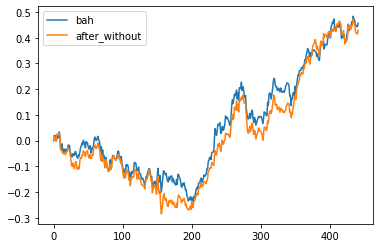

198 9 201


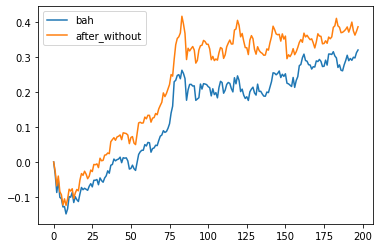

Episode 0/3000 and so far the performance is 2.6546648576959835 and loss is 0.028025155887007713
Episode 20/3000 and so far the performance is 3.5934946709839815 and loss is 1.4345960153150372e-06
Episode 40/3000 and so far the performance is 3.5934946709839815 and loss is 4.4406641563909943e-07
Episode 60/3000 and so far the performance is 3.5934946709839815 and loss is 4.2953720935656747e-07
Episode 80/3000 and so far the performance is 3.5934946709839815 and loss is 3.4836193663068116e-07
Episode 100/3000 and so far the performance is 3.5934946709839815 and loss is 2.8672889129666146e-07
Episode 120/3000 and so far the performance is 3.5934946709839815 and loss is 4.112106353204581e-07
Episode 140/3000 and so far the performance is 3.5934946709839815 and loss is 2.70020763082357e-07
Episode 160/3000 and so far the performance is 3.5934946709839815 and loss is 3.715030061357538e-07
Episode 180/3000 and so far the performance is 3.5934946709839815 and loss is 3.4006950500042876e-07
Ep

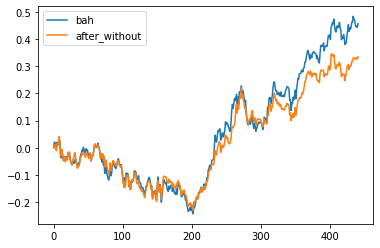

198 9 201


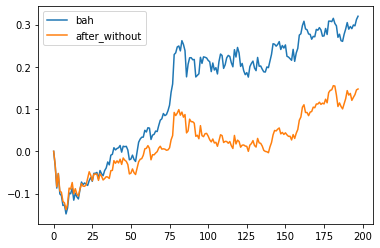

Episode 0/3000 and so far the performance is 2.78990576657647 and loss is 14.512548446655273
Episode 20/3000 and so far the performance is 3.939075174767766 and loss is 0.3378458023071289
Episode 40/3000 and so far the performance is 3.939075174767766 and loss is 1.324889854004141e-05
Episode 60/3000 and so far the performance is 3.939075174767766 and loss is 7.206612281152047e-06
Episode 80/3000 and so far the performance is 3.939075174767766 and loss is 4.945459295413457e-06
Episode 100/3000 and so far the performance is 3.939075174767766 and loss is 2.535105977585772e-06
Episode 120/3000 and so far the performance is 3.939075174767766 and loss is 3.3192936825798824e-06
Episode 140/3000 and so far the performance is 3.939075174767766 and loss is 3.006799943250371e-06
Episode 160/3000 and so far the performance is 3.939075174767766 and loss is 7.471400635949976e-07
Episode 180/3000 and so far the performance is 3.939075174767766 and loss is 1.962482201633975e-06
Episode 200/3000 and s

In [ ]:
def train_learning_rate(lrs = [0.01, 0.05, 0.1]):
    train_data, train_image_data, _, train_open_price = get_security_list(start = '2018-01-01', end = '2019-12-31')
    test_data, test_image_data, _, test_open_price = get_security_list(start = '2020-01-01', end = '2020-12-31')
    for lr in lrs:
        agent = train_model(data = train_data, image_data = train_image_data, lr = lr, max_episodes=3000)
        evalModelPerformance(agent, train_image_data, train_open_price)
        evalModelPerformance(agent, test_image_data, test_open_price)
train_learning_rate()

198 9 201


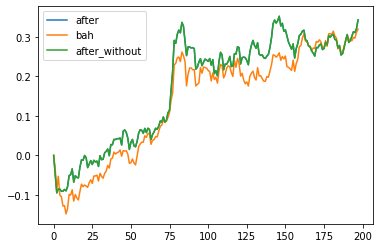

In [33]:
#test_data, test_image_data, _, test_open_price = get_security_list(start = '2020-01-01', end = '2020-12-31')
#print(len(test_image_data), len(test_open_price[0]))
evalModelPerformance(test_image_data, test_open_price)

443 445
442 9 445


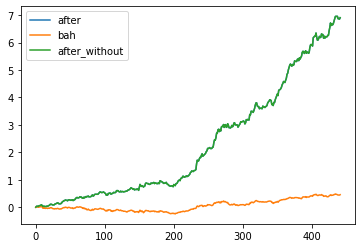

In [35]:
#data, image_data, _, open_price = get_security_list(start = '2018-01-01', end = '2019-12-31')
print(len(image_data), len(open_price[0]))
evalModelPerformance(image_data, open_price)